In [1]:
# ESSENTIALS
import numpy as np
import matplotlib.pyplot as plt
import glob, os
from datetime import datetime

# CLUSTERING AND RANDOM FOREST
import skfuzzy as fuzz
from sklearn import tree
from sklearn import model_selection
from sklearn.datasets import make_blobs
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.svm import *
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay

# DATA LIBRARIES
# import rasterio
# import contextily as cx
import geopandas as gpd
import pandas as pd
import json
import pickle
import xarray
from xarray.core.dataarray import DataArray


# PREFERENCES
pd.set_option('display.max_columns', 500)
plt.rcParams['figure.dpi'] = 400
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams.update({'font.size': 14})

In [2]:
class ModelSelector():

    def __init__(self, c_kwargs={}, rf_kwargs={}):
       self.c_kwargs=c_kwargs        # CLUSTERING HYPERPARAMETERS
       self.rf_kwargs=rf_kwargs      # RANDOM FOREST HYPERPARAMETERS
       self.m = 2                    # EXPONENTIATION COEFFICIENT FOR CLUSTERING. TODO: MAKE ADJUSTABLE

    def fuzzyCluster(self, data):
        # Wraps Fuzzy Cluster function, only outputting percent belongs and formal cluster.

        # CHECK THAT REQUIRED FIELDS ARE IN KWARGS, IF NOT ADD
        if "error" not in self.c_kwargs:
            self.c_kwargs['error']=0.005

        if "maxiter" not in self.c_kwargs:
            self.c_kwargs['maxiter']=1000

        cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(data.T, self.n_centers, self.m, **self.c_kwargs)
        label = np.argmax(u, axis=0)
        return cntr, u, fpc, label

    def howManyClusters(self, X, mintest=2,maxtest=15):
        # Determines how many clusters should be used using the Fuzzy Partitions Coefficient (FPC)
        # https://scikit-fuzzy.github.io/scikit-fuzzy/auto_examples/plot_cmeans.html#example-plot-cmeans-py
        # TODO: FIGURE OUT IF THIS METHOD IS APPROPRIATE OR NOT
        return 3
        fpcs = []
        listtests = np.arange(mintest,maxtest)
        for ncenters in listtests:
            self.n_centers = ncenters
            _, _, fpc, _ = self.fuzzyCluster(X)
            fpcs.append(fpc)
        return listtests[np.argmax(fpcs)]

    def train_rf(self, X_train, y_train, rf_controls={}):
        # ADAPTED FROM https://stackoverflow.com/questions/28489667/combining-random-forest-models-in-scikit-learn

        # RF CONTROLS PASSED DIRECTLY FROM PARAMETER, DEFAULT IS EMPTY
        rf = RandomForestRegressor(**rf_controls) 

        # RF FITTING 
        rf.fit(X_train, y_train)

        return rf

    def fit(self, attributes, model_perf):

        # CREATE RANDOM FOREST AND TRAIN
        self.rf = self.train_rf(attributes, model_perf, rf_controls=self.rf_kwargs)
        # print(r2_score(self.rf.predict(attributes), model_perf))

        return self

    def predict(self, attributes):

        # CHECK WHETHER MODEL HAS BEEN TRAINED
        if self.rf is None:
            raise(Exception("ModelSelector isn't trained!"))

        # GET RANDOM FOREST PREDICTION
        pred = self.rf.predict(attributes)


        return pred

In [3]:
# ADAPTED FROM https://github.com/neuralhydrology/neuralhydrology/blob/1ff36ea8c8eff99ad25fa0f56f0119acbc9e6799/neuralhydrology/evaluation/metrics.py
def nse(obs: DataArray, sim: DataArray) -> float:
    denominator = ((obs - obs.mean())**2).sum()
    numerator = ((sim - obs)**2).sum()
    value = 1 - numerator / denominator
    return float(value)

def getFeatureImportance(selector, testidx, input, output, xx, reps=10):
    # USING FULL PERMUTATION IMPORTANCE, AS OUTLINED IN 
    # https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
    result = permutation_importance(selector.rf, input.iloc[testidx, :], output.iloc[testidx], n_repeats=reps, random_state=42, n_jobs=2)
    means = pd.Series(result.importances_mean, index=list(input)) 
    std = pd.Series(result.importances_std, index=list(input))
    df = pd.concat([means, std], axis=1)
    df.columns = [str(xx) + "_mean", str(xx) + "_std"]
    return df


def runFitMetric_getMSE(fitmet, rf_kwargs={}):
    # FILEPATH TO SHAPEFILE CONTAINING CAMELS DATASET
    # camelsdir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\HCDN_nhru_final\HCDN_nhru_final_671.shp"
    camelsdir = r"/home/ottersloth/ensemblennse/data/data/HCDN_nhru_final/HCDN_nhru_final_671.shp"
    
    # DIRECTORY TO FOLDER CONTAINING CAMELS ATTRIBUTE TEXTFILES
    # PRIOR TO THIS STEP MAKE SURE THE README IN THE FILE SYSTEM HAS BEEN REMOVED (or the file extension has been changed)
    attdir = r"/home/ottersloth/ensemblennse/data/data/camels_attributes_v2.0/camels_attributes_v2.0/"

    # READ CAMELS DATASET
    camels = gpd.read_file(camelsdir)

    # COPY TO KEEP ORIGINAL IN MEMORY
    camels_df = camels 

    # LOOP THROUGH AND JOIN
    filelist = glob.glob(attdir + "*.txt")
    for i in filelist:
        currdf = pd.read_csv(i, sep=";")
        camels_df = camels_df.merge(currdf, how='left', left_on="hru_id", right_on="gauge_id")

    # DEFINE WHAT WE WANT TO RUN ON
    # perf_dir = r"C:\Users\franc\OneDrive - University Of Houston\000_SIResearch\data\hourly_performances\\"
    perf_dir = r"/home/ottersloth/ensemblennse/data/data/hourly_performances/"
    
    perf_metrics = [fitmet]

    # READ ALL CSV FILES IN DIRECTORY
    os.chdir(perf_dir)
    modelfiles = glob.glob("*.csv")

    # GET FIRST CSV FILE TO DEFINE DATAFRAME AND ADD PREFIX TO COLUMNS BASED ON NAME
    print(perf_dir + modelfiles[0])
    perf = pd.read_csv(perf_dir + modelfiles[0]).add_prefix(modelfiles[0][:-4] + "_")
    # GET COLUMN NAME CONTAINING "BASIN"
    fcol = [col for col in perf.columns if 'basin' in col]

    # LOOP FOR EACH CSV FILE
    for ii in range(1, len(modelfiles)):
        print(perf_dir + modelfiles[ii])
        # GET NEXT CSV FILE TO DEFINE DATAFRAME AND ADD PREFIX TO COLUMNS BASED ON NAME
        currdf = pd.read_csv(perf_dir + modelfiles[ii]).add_prefix(modelfiles[ii][:-4] + "_")

        # GET COLUMN NAME CONTAINING "BASIN"
        basin_col= [col for col in currdf.columns if 'basin' in col]
        # JOIN ON MATCHING BASINS
        perf = perf.merge(currdf, how="inner", left_on=fcol, right_on=basin_col)
    
    # GET COLUMN NAME CONTAINING "FITMET"
    perf_met = [col for col in perf.columns if fitmet in col]

    # CLEAN UP NONSENSICAL DATA (EG, BASIN LABELS)
    # SO LETS GET A LIST OF VARIABLE NAMES WE WANT TO KEEP.

    # TO START WE WILL KEEP THE SAME VARIABLES AS Kratzert et al. 2019, AS SHOWN BY OUR
    # INTERNAL SPREADSHEET Attributes_CAMELS_vs_NHDPlus
    varstokeep = ['organic_frac',
    'elev_mean_x',
    'slope_mean',
    'area_gages2',
    'soil_depth_pelletier',
    'sand_frac',
    'silt_frac',
    'clay_frac',
    'geol_permeability',
    'p_mean',
    'pet_mean',
    'aridity',
    'frac_snow',
    'high_prec_freq',
    'high_prec_dur',
    'low_prec_freq',
    'low_prec_dur']

    camels_df = camels_df.merge(perf, how="inner", left_on="hru_id", right_on=fcol)
    
    inputdataset = camels_df[varstokeep]
    outputdataset = camels_df[perf_met]
    
    
    nsplits = 5
    kf = KFold(n_splits=nsplits, shuffle=True)


    testvalues = np.zeros((inputdataset.shape[0], outputdataset.shape[1]))                  # CONTAINER FOR PERFORMANCE VALUES WHEN BASIN IN TEST SET
    modelno = 0                                                              # COUNTER FOR MODEL CONTAINER
    test_modelno = np.zeros((inputdataset.shape[0], outputdataset.shape[1]))                # MODEL IN WHICH BASIN WAS IN TEST SET
    test_modellist = list()                                                  # MODEL CONTAINER
    featureimportance = list()
    r2train = list()
    r2test = list()
    msetest = list()
    msetrain = list()
    msemeta = list()
    trainlist_x = list()
    trainlist_y = list()

    currout=outputdataset

    # KFOLD SPLIT OF DATASETS
    for train, test in kf.split(inputdataset):            
        # CODE FOR INDIVIDUAL MODEL TRAINING
        for ii in range(currout.shape[1]):
            # TRAIN MODEL ON TRAINING SET
            model = None
            model = ModelSelector(rf_kwargs=rf_kwargs)
            model.fit(inputdataset.iloc[train, :], currout.iloc[train, ii])

            # PERFORM PREDICTION ON TRAIN SET AND GET FIT METRICS
            train_pred = model.predict(inputdataset.iloc[train, :])
            trainrms = mse(train_pred, currout.iloc[train, ii].to_numpy())
            trainr2 = r2_score(train_pred, currout.iloc[train, ii].to_numpy())

            # PERFORM PREDICTION ON TEST SET AND GET FIT METRICS
            model_pred = model.predict(inputdataset.iloc[test, :])
            testrms = mse(model_pred, currout.iloc[test, ii].to_numpy())
            testr2 = r2_score(model_pred, currout.iloc[test, ii].to_numpy())
            
            # GET FEATURE 
            fi = getFeatureImportance(model, test, inputdataset, currout.iloc[:,ii], modelno)
            featureimportance.append(fi)

            # SAVE VALUES IN CONTAINERS ABOVE
            testvalues[test, ii] = model_pred
            test_modelno[test, ii] = modelno
            modelno = modelno + 1
            test_modellist.append(model)
            msetest.append(testrms)
            msetrain.append(trainrms)
            r2train.append(trainr2)
            r2test.append(testr2)
            trainlist_x.append(train_pred)
            trainlist_y.append(outputdataset.iloc[train, :])

            # print(f"Test R2: {testr2:.3f} | Meta R2: {metar2:.3f} | Test MSE: {testrms:.3f} | Meta MSE: {metarms:.3f} | Model ID: {ii}")

    metrics = (r2train, r2test, msetrain, msetest)
    trainlists = (trainlist_x, trainlist_y)
    
    return camels_df, inputdataset, outputdataset, testvalues, test_modelno, test_modellist, featureimportance, metrics, trainlists

def softmax(x):
    # ADAPTED FROM https://www.delftstack.com/howto/numpy/numpy-softmax/
    maxx = np.max(x,axis=1,keepdims=True) #returns max of each row and keeps same dims
    e_x = np.exp(x - maxx) #subtracts each row with its max value
    sumx = np.sum(e_x,axis=1,keepdims=True) #returns sum of each row and keeps same dims
    f_x = e_x / sumx 
    return f_x

def ensemblePerf(perf, target, threshold=0.2, n=1, softmaxflag = False):
    # TODO: CONSIDER DOING A MORE ROBUST THING WERE YOU CALCULATE THE DIFFERENCE
    # BETWEEN EACH PERFORMANCE AND THE MINIMUM OF THE ROW WITHOUT ITSELF
    # THEN, RUN A NP.WHERE TO ESTABLISH THAT IF BIGGER THAN THRESHOLD, SET TO NAN
    # AND CALCULATE THE NORMALIZED PERFORMANCE FROM THERE, ONLY NECESSARY WITH MORE THAN
    # 2 MODELS

    # RANGE OF EACH ROW
    rn = np.max(perf, axis=1) - np.min(perf, axis=1)
    
    # THIS IS THE BEST PREDICTED MODEL
    # CALCULATED AS THE MAXIMUM OF THE PREDICTED PERFORMANCES
    # BEST PRED MODEL = BPM
    bpm_idx = np.argmax(perf, axis=1)
    bpm_perf = perf[np.arange(perf.shape[0]), bpm_idx]

    # CALCULATE THE VALUES FOR ENSEMBLING MODELS
    
    # EXPONENTIAL SETUP
    if not softmaxflag:
        perf_w = perf ** n
        row_sums = perf_w.sum(axis=1)
        perf_norm = perf_w / row_sums[:, np.newaxis]
    else: 
        perf_norm = softmax(perf)
    
    ens_perf = np.sum(target * perf_norm, axis=1)

    # THIS IS THE BEST ACTUAL MODEL
    # CALCULATED AS THE MAXIMUM OF THE ACTUAL PERFORMANCES
    # BEST ACTUAL MODEL = BAM
    target_perf = target.to_numpy()
    bam_idx = np.argmax(target_perf, axis=1)
    bam_perf = target_perf[np.arange(perf.shape[0]), bam_idx]
    
    # CREATE OUTPUT STRUCTURE
    output = np.where(rn < threshold, ens_perf, bam_perf)
    exceed = np.where(rn > threshold, True, False)
    
    print(f"Weighting in {perf.shape[0] - np.where(exceed)[0].shape[0]} basins")
    
    perf_norm[exceed, :] = 0
    perf_norm[np.where(exceed), bpm_idx[exceed]] = 1

    return output, perf_norm

def getLSTMTS(lstm_dir = '/home/ottersloth/neuralhydrology/nextgen-form-eval/run_hourly/runs/full_runs/runs/'):
    file_list = os.listdir(lstm_dir)
    file_list.remove('failed_runs')
    file_list.remove('hydro_signatures')

    num_files = len(file_list)

    lstm_results = {}
    lstm_results['basin_id'] = []
    lstm_results['sim'] = []

    for i in range(num_files): 
        lstm_test_dir = os.path.join(lstm_dir,file_list[i])
        lstm_test_file = os.path.join(lstm_test_dir,"test", "model_epoch003","test_results.p")
        with open(lstm_test_file, "rb") as fp:
            results = pickle.load(fp)

        basin_id = [i for i in results.keys()]

        for j in range(len(basin_id)):
            sim = results[basin_id[j]]['1H']['xr']['QObs_CAMELS(mm/h)_sim'].values
            sim = [float(sim[i]) for i in range(len(sim))]

            lstm_results['sim'].append(sim)
            lstm_results['basin_id'].append(basin_id[j])

    df_lstm_results = pd.DataFrame(lstm_results)
    return df_lstm_results

def getWeightedFit(rfargs = {"n_estimators": 15}, weightparams={"threshold":0.2, "n":1, "softmax": False}):
    
    # RUN RF MODELS AND GET OUT OF BAG (OOB) "TESTVALUES"
    camels_df, inputs, target, testvalues, test_modelno, test_modellist, featureimportance, metrics, trainlists = runFitMetric_getMSE("nnse",rf_kwargs=rfargs)
    outstruct_rf = (camels_df, inputs, target, testvalues, test_modelno, test_modellist, featureimportance, metrics, trainlists)
    
    # GET WEIGHTS FROM OOB TESTVALUES
    _, weights = ensemblePerf(testvalues, target, **weightparams)
    
    # ADD WEIGHTS TO CAMELS AND DEFINE RUNNING DF 
    camels_df['weight_CFE'] = weights[:, 0]
    camels_df['weight_LSTM'] = weights[:, 1]
    weights_df = camels_df[['hru_id', 'weight_CFE', 'weight_LSTM']]
    
    # GET TIMSERIES OF LSTM RESULTS
    df_lstm_results = getLSTMTS()
    
    # DEFINE DIR WITH ALL STREAMFLOW DATA 
    q_dir = "/home/ottersloth/data/camels_hourly/usgs_streamflow"

    # TEST PERIOD
    test_start=datetime.strptime("2002-09-30 23:00:00", '%Y-%m-%d %H:%M:%S')
    # ORIGINALLY UNTIL 11 PM, CHANGED BECAUSE COMPARISON FUNCTION IS INCLUSIVE LATER ON
    test_end=datetime.strptime("2007-09-30 22:00:00", '%Y-%m-%d %H:%M:%S') 

    # GET ALL CFE VALIDATION FILES 
    cfe_dir = "/home/ottersloth/cfe_calibration/results/val_runs/"
    os.chdir(cfe_dir)
    filelist = glob.glob("*.json")

    basinlist = list()
    outnnselist = list()


    for i in range(len(filelist)): 

        # GET FILE NAME FROM CONTAINER
        file = filelist[i]

        # GET BASIN ID BY SPLITTING FILENAME
        basinid_raw = file.split("_")[0]
        basinid = '%08d' % int(basinid_raw) # ZERO PADDING

        # GET TIMESERIES FROM LSTM DATAFRAME
        match = df_lstm_results[df_lstm_results["basin_id"] == basinid]

        # SINCE NOT THE SAME BASINS WERE RUN, CHECK WE ACTUALLY GOT A MATCH
        if match.shape[0] != 1:
            print(f"Skipping {basinid}")
            continue

        # CONVERT TIMESERIES TO NP ARRAY
        ts_lstm = np.array(match.iloc[0, 1])

        # NOW READ CFE FILE
        with open(file) as json_file:
            data = json.load(json_file)

        # CONVERT TIMESERIES TO NUMPY ARRAY
        ts_cfe = np.array(data['validation sims'])

        # GET MODEL WEIGHTS 
        weights = weights_df[weights_df["hru_id"] == int(basinid)].to_numpy()
        weights = weights[0][1:]

        # weights = weights[1:]

        # APPLY WEIGHTS
        ts_final = (weights[0] * ts_cfe + weights[1] * ts_lstm)

        # GET Q FROM USGS FOR TEST PERIOD
        q_read = pd.read_csv(f"{q_dir}/{basinid}-usgs-hourly.csv")
        q_read["datetime"] = pd.to_datetime(q_read['date'], format='%Y-%m-%d %H:%M:%S') # CONVERT TO DATETIME
        q_match = q_read[q_read.datetime.between(test_start, test_end)]
        ts_q = q_match['QObs_CAMELS(mm/h)'].to_numpy()

        # CALCULATE NSE 
        nse_calc = nse(ts_q, ts_final)

        # CALCULATE NNSE
        nnse = 1 / (2 - nse_calc)

        # print(f"{basinid} {nnse}")
        if i % 100 == 0:
            print(f"{i} / {len(filelist)}")

        # SAVE IN PROPER FORMAT
        basinlist.append(basinid)
        outnnselist.append(nnse)
        
    return basinlist, outnnselist, outstruct_rf

In [4]:
basins, nnse, outstruct = getWeightedFit(rfargs = {"n_estimators": 15}, weightparams={"threshold":0.1, "n":1, "softmaxflag": False})

camels_df, inputdataset, outputdataset, testvalues, test_modelno, test_modellist, featureimportance, metrics, trainlists = outstruct

/home/ottersloth/ensemblennse/data/data/hourly_performances/LSTM.csv
/home/ottersloth/ensemblennse/data/data/hourly_performances/CFE.csv


/home/ottersloth/anaconda3/envs/ensemble/lib/python3.8/site-packages/geopandas/geodataframe.py:1483: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)
/home/ottersloth/anaconda3/envs/ensemble/lib/python3.8/site-packages/geopandas/geodataframe.py:1483: FutureWarning: Passing 'suffixes' which cause duplicate columns {'gauge_id_x'} in the result is deprecated and will raise a MergeError in a future version.
  result = DataFrame.merge(self, *args, **kwargs)


Weighting in 198 basins
0 / 495
100 / 495
200 / 495
300 / 495


/tmp/ipykernel_225544/4245744917.py:314: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  q_read = pd.read_csv(f"{q_dir}/{basinid}-usgs-hourly.csv")


400 / 495


Text(0.5, 1.0, 'Variable Importance for Different Models via RF Permutation')

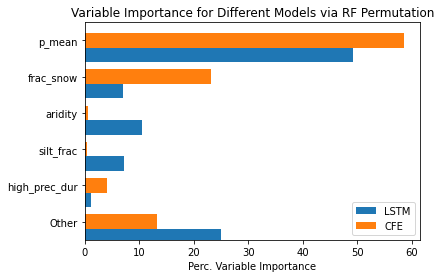

In [5]:
plt.rcParams['figure.figsize'] = (10, 15)

def getList(r):

    features = featureimportance[0].shape[0] # NUMBER OF FEATURES
    sum = np.zeros((features, ))
    ss = np.zeros((features, ))
    for i in r:
        # POOL MEANS AND STANDARD DEVIATIONS:
        # - GROUP MEAN IS MEAN OF ALL MEANS 
        # - GROUP STD IS DEFINED BY SQRT(SUM(STDs^2)), SINCE ALL SAMPLE SIZES ARE EQUAL
        currdf = featureimportance[i]
        sum = sum + currdf[str(i) + "_mean"].to_numpy().T
        ss =  ss + currdf[str(i) + "_std"].to_numpy().T

    means = sum / len(featureimportance)
    std = np.sqrt(ss)  
    
    return np.abs(means)

n_models = 2
n_folds = 5
topn = 5
width = .4

lstm = np.arange(0, n_models*n_folds, 2)
cfe = np.arange(1, n_models*n_folds, 2)

lstm_sc = getList(lstm)
cfe_sc = getList(cfe)

comb_imp = lstm_sc + cfe_sc
ind = np.argsort(comb_imp)[-topn:]# np.argpartition(comb_imp, topn)[-topn:]

other = np.arange(0, featureimportance[0].shape[0])
other = other[np.logical_not(np.isin(other, ind))]

x = np.arange(0, ind.shape[0]+1)

figs, ax = plt.subplots()


labels = np.array(list(featureimportance[0].index.values))
labels = labels[ind]
labels = np.insert(labels,  0, "Other")

lstm_sc_t = lstm_sc[ind]
cfe_sc_t = cfe_sc[ind]


lstm_sc_t = np.insert(lstm_sc_t, 0, np.sum(lstm_sc[other]))
cfe_sc_t = np.insert(cfe_sc_t, 0, np.sum(cfe_sc[other]))

# NORMALIZE TO PERCENT
cfe_sc_t = cfe_sc_t/cfe_sc_t.sum()
lstm_sc_t = lstm_sc_t/lstm_sc_t.sum()


rects1 = ax.barh(x - width, lstm_sc_t*100, width, label='LSTM')
rects2 = ax.barh(x, cfe_sc_t*100, width, label='CFE')

ax.legend()
ax.set_yticks(x, labels, fontsize=10)
ax.set_xlabel("Perc. Variable Importance")
ax.set_ylim((-.5,topn+.5))
#ax.set_xscale('log')
ax.set_title("Variable Importance for Different Models via RF Permutation")

In [6]:
outputdataset.head()

,LSTM_nnse,CFE_nnse
0,0.795679,0.702071
1,0.866430,0.657231
2,0.833751,0.638119
3,0.766951,0.505420
4,0.719024,0.532733


In [7]:
n_models = 2
n_folds = 5
topn = 5
width = .4

# -------------EXTREMELY IMPORTANT------------------------------------------- 
# DEFINE THE STARTING INDICES OF THESE LISTS AS THE SAME AS SHOWN IN THE CODE
# BLOCK ABOVE (ie, FIRST COLUMN = 0)
cfe_i = 1
lstm_i = 0

cfe_idx = np.arange(cfe_i, n_models*n_folds, 2)
lstm_idx = np.arange(lstm_i, n_models*n_folds, 2)

Text(0.5, 1.0, 'CFE')

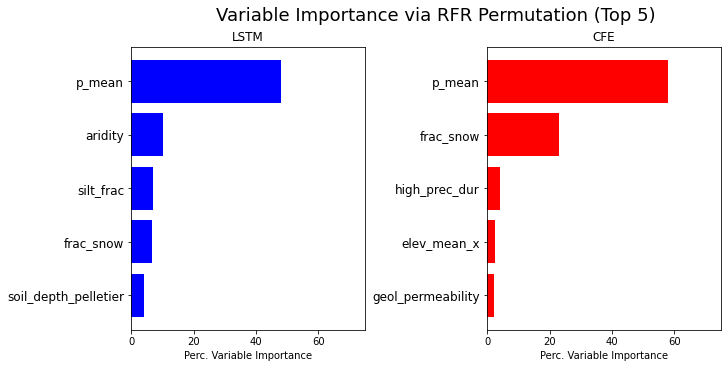

In [8]:
plt.rcParams['figure.figsize'] = (10, 5)

def getList(r, ax, c, topn=5):

    features = featureimportance[0].shape[0] # NUMBER OF FEATURES
    sum = np.zeros((features, ))
    ss = np.zeros((features, ))
    for i in r:
        # POOL MEANS AND STANDARD DEVIATIONS:
        # - GROUP MEAN IS MEAN OF ALL MEANS 
        # - GROUP STD IS DEFINED BY SQRT(SUM(STDs^2)), SINCE ALL SAMPLE SIZES ARE EQUAL
        currdf = featureimportance[i]
        sum = sum + np.abs(currdf[str(i) + "_mean"].to_numpy()).T
        ss =  ss + currdf[str(i) + "_std"].to_numpy().T

    means = sum / len(featureimportance)
    means = means/means.sum() * 100 # NORMALIZE TO PERCENT
    
    std = np.sqrt(ss)  
    
    ind = np.argsort(means)[-topn:]
    
    labels = featureimportance[0].index.values[ind]
    selmeans = means[ind]
    
    # REVERSE TO SHOW IN DESCENDING ORDER
    #selmeans = selmeans[::-1]
    #labels = labels[::-1]
    
    ax.barh(np.arange(selmeans.shape[0]), selmeans, color=c)
    ax.set_yticks(np.arange(selmeans.shape[0]))
    ax.set_yticklabels(labels, fontsize=12)
    ax.set_xlim((0, 75))
    ax.set_xlabel("Perc. Variable Importance")
    
    return ax


figs, axs = plt.subplots(1,2, constrained_layout=True, facecolor="white")

figs.suptitle('Variable Importance via RFR Permutation (Top 5)', fontsize=18, x=0.6)
axs[0] = getList(lstm_idx, axs[0], 'blue')
axs[0].set_title("LSTM")
axs[1] = getList(cfe_idx, axs[1], 'red')
axs[1].set_title("CFE")

In [9]:
lstm_trainr2  = np.array(metrics[0])[lstm_idx]
lstm_testr2   = np.array(metrics[1])[lstm_idx]
lstm_trainmse = np.array(metrics[2])[lstm_idx]
lstm_testmse  = np.array(metrics[3])[lstm_idx]


cfe_trainr2  = np.array(metrics[0])[cfe_idx]
cfe_testr2   = np.array(metrics[1])[cfe_idx]
cfe_trainmse = np.array(metrics[2])[cfe_idx]
cfe_testmse  = np.array(metrics[3])[cfe_idx]

(10, 396)
(10, 396, 2)
(1980,)
(1980,)


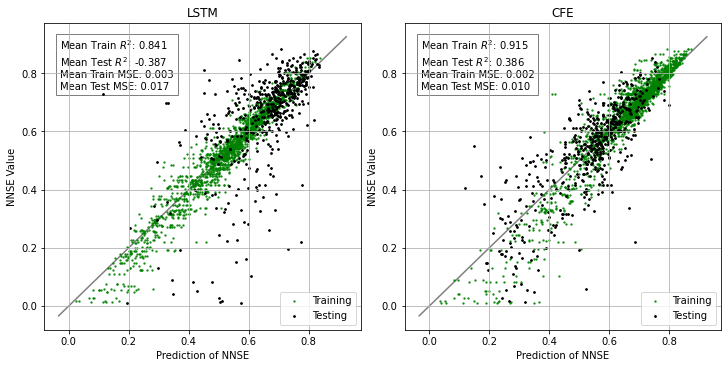

In [10]:
def prettify(ax, title, string):
    props = dict(facecolor='white', alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel("Prediction of NNSE")
    ax.set_ylabel("NNSE Value")
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'k-', alpha=.5, zorder=0)
    ax.text(0.05, 0.95, string, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=props, zorder=0)
    ax.legend(loc="lower right")
    ax.grid()
    return ax

def getTrain(trainlists):
    x, y = trainlists
    x = np.array(x)
    y = np.array(y)
    print(x.shape)
    print(y.shape)
    
    x_cfe = x[cfe_idx,:].flatten()
    y_cfe = y[cfe_idx,:,cfe_i].flatten()
    
    x_lstm = x[lstm_idx].flatten()
    y_lstm = y[lstm_idx,:, lstm_i].flatten()
    return x_cfe, y_cfe, x_lstm, y_lstm

pred_cfe, true_cfe, pred_lstm, true_lstm = getTrain(trainlists)

print(pred_cfe.shape)
print(true_cfe.shape)

cfestr = f"Mean Train $R^2$: {cfe_trainr2.mean():.3f}\nMean Test $R^2$: {cfe_testr2.mean():.3f}\nMean Train MSE: {cfe_trainmse.mean():.3f}\nMean Test MSE: {cfe_testmse.mean():.3f}"
lstmstr = f"Mean Train $R^2$: {lstm_trainr2.mean():.3f}\nMean Test $R^2$: {lstm_testr2.mean():.3f}\nMean Train MSE: {lstm_trainmse.mean():.3f}\nMean Test MSE: {lstm_testmse.mean():.3f}"

fig, axs = plt.subplots(1, 2, constrained_layout=True, facecolor="white")

axs[0].scatter(pred_cfe, true_cfe, s=2, color="green", alpha=.75, label="Training")
axs[0].scatter(testvalues[:, lstm_i], outputdataset['LSTM_nnse'], s=3, color="black", label="Testing")

axs[1].scatter(pred_lstm, true_lstm, s=2, color="green", alpha=.75, label="Training")
axs[1].scatter(testvalues[:, cfe_i], outputdataset['CFE_nnse'], s=3, color="black", label="Testing")


axs[0] = prettify(axs[0], "LSTM", lstmstr)
axs[1] = prettify(axs[1], "CFE", cfestr)

Text(0, 0.5, 'NNSE')

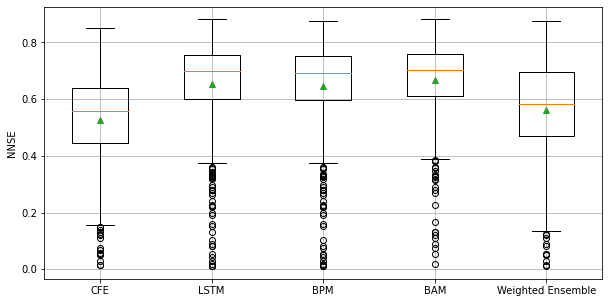

In [11]:
target = outputdataset

# THIS IS THE BEST PREDICTED MODEL
# CALCULATED AS THE MAXIMUM OF THE PREDICTED PERFORMANCES
# BEST PRED MODEL = BPM
bpm_idx = np.argmax(testvalues, axis=1)
bpm_perf = testvalues[np.arange(testvalues.shape[0]), bpm_idx]

# THIS IS THE BEST ACTUAL MODEL
# CALCULATED AS THE MAXIMUM OF THE ACTUAL PERFORMANCES
# BEST ACTUAL MODEL = BAM
target_perf = target.to_numpy()
bam_idx = np.argmax(target_perf, axis=1)
bam_perf = target_perf[np.arange(testvalues.shape[0]), bam_idx]


# ACTUAL MODEL PERFORMANCE = AMP
amp = target.to_numpy()

cfe = amp[:, cfe_i]
cfe_est = testvalues[:, cfe_i]

lstm = amp[:, lstm_i]
lstm_est = testvalues[:, lstm_i]

bestpred_est = testvalues[np.arange(amp.shape[0]), bpm_idx]
bestpred_real = amp[np.arange(amp.shape[0]), bpm_idx]

bestmodel = bam_perf

# perf_models = [cfe_est, cfe, lstm_est, lstm, bestpred_est, bestpred_real, bestmodel]
# labs = ["CFE\nRFR", "CFE\nActual", "LSTM\nRFR","LSTM\nActual", "BPM\nRFR", "BPM\nActual", "BAM"]

perf_models = [cfe, lstm, bestpred_real, bestmodel, nnse]
labs = ["CFE", "LSTM", "BPM", "BAM", "Weighted Ensemble"]

plt.boxplot(perf_models, labels=labs, showmeans=True)
plt.grid()
plt.ylabel("NNSE")

Text(0, 0.5, 'NNSE')

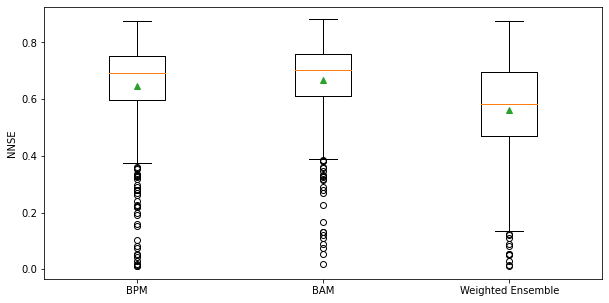

In [12]:


perf_models = [bestpred_real, bestmodel, nnse]
labs = ["BPM", "BAM", "Weighted Ensemble"]
# 

plt.boxplot(perf_models, labels=labs, showmeans=True)
plt.ylabel("NNSE")

In [13]:
perf_ensemble = pd.DataFrame(basins, columns=["basin_id"])
perf_ensemble["ensemble"] = nnse


bam_df = camels_df[["hru_id"]].copy()
bam_df['basin_id'] = bam_df['hru_id'].astype(str).str.zfill(8)
bam_df["bam"] = bam_perf
bam_df["bpm"] = bestpred_real

perf_df = bam_df.merge(perf_ensemble, on="basin_id")

perf_df.head()

,hru_id,basin_id,bam,bpm,ensemble
0,1022500,01022500,0.795679,0.795679,0.698920
1,1031500,01031500,0.866430,0.866430,0.655483
2,1047000,01047000,0.833751,0.833751,0.636399
3,1052500,01052500,0.766951,0.766951,0.504812
4,1054200,01054200,0.719024,0.719024,0.535598


132 basins where ensemble outperformed BAM, 171 where outperformed BPM


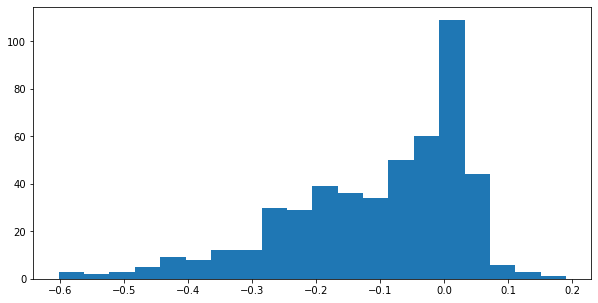

In [17]:
perf = perf_df
perf["ensemble_d"] = perf["ensemble"] - perf["bam"]
perf["ensemble_p"] = perf["ensemble"] - perf["bpm"]
plt.hist(perf["ensemble_d"], bins=20)
print(f'{perf[perf["ensemble_d"] > 0].shape[0]} basins where ensemble outperformed BAM, {perf[perf["ensemble_p"] > 0].shape[0]} where outperformed BPM')